In [1]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume, Returns, AnnualizedVolatility, CustomFactor
from zipline.utils.calendars import get_calendar
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.loaders.equity_pricing_loader import USEquityPricingLoader
from zipline.pipeline.data import USEquityPricing

from zipline.data.bundles import register
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.data import bundles

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [3]:
os.environ['ZIPLINE_ROOT'] = r'C:\Users\Leo\.zipline'
#os.environ['ZIPLINE_ROOT'] = '/home/leo/.zipline/'

In [4]:
start_session = pd.Timestamp('2016-6-26', tz = 'utc')
end_session = pd.Timestamp('2019-6-26', tz = 'utc')

register(
	'crypto_portfolio',
	csvdir_equities(
		['daily'], 
		r'D:\Git Projects\portfolio_analytics\data', 
		), 
	calendar_name = '24/7',
	start_session = start_session,
	end_session = end_session
	)

<bound method CSVDIRBundle.ingest of <zipline.data.bundles.csvdir.CSVDIRBundle object at 0x0000021DDA528B00>>

In [5]:
bundle_data = bundles.load('crypto_portfolio')

In [6]:
universe = AverageDollarVolume(window_length = 7).rank(ascending = False) <= 8 
trading_calendar = get_calendar('24/7') 

In [7]:
class RegressionAgainstTime(CustomFactor):

    #TODO: choose a window length that spans one year's worth of trading days
    window_length = 30
    
    #TODO: use USEquityPricing's close price
    inputs = [USEquityPricing.close]
    
    #TODO: set outputs to a list of strings, which are names of the outputs
    #We're calculating regression coefficients for two independent variables, 
    # called beta and gamma
    outputs = ['beta', 'gamma']
    
    def compute(self, today, assets, out, dependent):
        
        #TODO: define an independent variable that represents time from the start to end
        # of the window length. E.g. [1,2,3...252]
        t1 = np.arange(self.window_length)
        
        #TODO: define a second independent variable that represents time ^2
        t2 = t1 ** 2
        
        # combine t1 and t2 into a 2D numpy array
        X = np.array([t1, t2]).T

    
        #TODO: the number of stocks is equal to the length of the "out" variable,
        # because the "out" variable has one element for each stock
        n_stocks = len(out)
        # loop over each asset

        for i in range(n_stocks):
            # TODO: "dependent" is a 2D numpy array that
            # has one stock series in each column,
            # and days are along the rows.
            # set y equal to all rows for column i of "dependent"
            y = dependent[:, i]
            
            # TODO: run a regression only if all values of y
            # are finite.
            if np.all(np.isfinite(y)) :
                # create a LinearRegression object
                regressor = LinearRegression()
                
                # TODO: fit the regressor on X and y
                regressor.fit(X, y)
                
                # store the beta coefficient
                out.beta[i] = regressor.coef_[0]
                
                #TODO: store the gamma coefficient
                out.gamma[i] = regressor.coef_[1]
            else:
                # store beta as not-a-number
                out.beta[i] = np.nan
                
                # TODO: store gammas not-a-number
                out.gamma[i] = np.nan

In [8]:
beta_factor = RegressionAgainstTime(mask=universe).beta.rank()
gamma_factor = RegressionAgainstTime(mask = universe).gamma.rank()

hist_return = Returns(window_length = 30, mask = universe).rank()
hist_volatility = AnnualizedVolatility(window_length = 30, mask = universe).rank(ascending = False)
hist_volume = AverageDollarVolume(window_length = 30, mask = universe).rank()
adv_momentum = (beta_factor * gamma_factor).rank()

comp_factor = (hist_return + hist_volatility + hist_volume + adv_momentum).rank()

In [9]:
p = Pipeline(screen = universe)
p.add(hist_return, 'hist_return')
p.add(hist_volatility, 'hist_volatility')
p.add(hist_volume, 'hist_volume')
p.add(adv_momentum, 'adv_momentum')
p.add(comp_factor, 'comp_factor')

In [10]:
# Very Useful Guidance on how to build the pipeline engine

from zipline.assets._assets import Equity
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.loaders import USEquityPricingLoader


#EOD_BUNDLE_NAME = 'cryptocompare_cryptocurrencies'


class PricingLoader(object):
    def __init__(self, bundle_data):
        self.loader = USEquityPricingLoader(
            bundle_data.equity_daily_bar_reader,
            bundle_data.adjustment_reader)

    def get_loader(self, column):
        if column not in USEquityPricing.columns:
            raise Exception('Column not in USEquityPricing')
        return self.loader


def build_pipeline_engine(bundle_data, trading_calendar):
    pricing_loader = PricingLoader(bundle_data)

    engine = SimplePipelineEngine(
        get_loader = pricing_loader.get_loader,
        calendar = trading_calendar.all_sessions,
        asset_finder = bundle_data.asset_finder)

    return engine

In [11]:
engine = build_pipeline_engine(bundle_data, trading_calendar)

In [12]:
alpha_vectors = engine.run_pipeline(p, start_session + pd.DateOffset(days = 31), end_session)

In [13]:
alpha_vectors

adv_momentum  comp_factor  \
2016-07-27 00:00:00+00:00 Equity(0 [BTC])            1.0          7.0   
                          Equity(2 [DASH])           8.0          8.0   
                          Equity(3 [DCR])            3.0          2.0   
                          Equity(6 [ETH])            2.0          3.0   
                          Equity(7 [LSK])            5.0          4.0   
                          Equity(8 [LTC])            4.0          5.0   
                          Equity(9 [MAID])           6.0          6.0   
                          Equity(11 [XEM])           7.0          1.0   
2016-07-28 00:00:00+00:00 Equity(0 [BTC])            1.0          7.0   
                          Equity(2 [DASH])           8.0          8.0   
                          Equity(3 [DCR])            3.0          2.0   
                          Equity(6 [ETH])            2.0          3.0   
                          Equity(7 [LSK])            5.0          4.0   
                          Equity(8 [LTC])            4.0          6.0   
                          Equity(9 [MAID])           6.0          5.0   
                          Equity(11 [XEM])           7.0          1.0   
2016-07-29 00:00:00+00:00 Equity(0 [BTC])            2.0          7.0   
                          Equity(2 [DASH])           8.0          8.0   
                          Equity(3 [DCR])            4.0          2.0   
                          Equity(6 [ETH])            3.0          5.0   
                          Equity(7 [LSK])            5.0          3.0   
                          Equity(8 [LTC])            1.0          4.0   
                          Equity(9 [MAID])           6.0          6.0   
                          Equity(11 [XEM])           7.0          1.0   
2016-07-30 00:00:00+00:00 Equity(0 [BTC])            2.0          6.0   
                          Equity(2 [DASH])           8.0          8.0   
                          Equity(3 [DCR])            5.0          2.0   
                          Equity(6 [ETH])            4.0          5.0   
                          Equity(7 [LSK])            1.0          3.0   
                          Equity(8 [LTC])            7.0          7.0   
...                                                  ...          ...   
2019-06-23 00:00:00+00:00 Equity(2 [DASH])           7.0          8.0   
                          Equity(3 [DCR])            6.0          5.0   
                          Equity(6 [ETH])            4.0          4.0   
                          Equity(7 [LSK])            5.0          3.0   
                          Equity(8 [LTC])            8.0          7.0   
                          Equity(11 [XEM])           1.0          1.0   
2019-06-24 00:00:00+00:00 Equity(0 [BTC])            2.0          7.0   
                          Equity(1 [BTS])            3.0          2.0   
                          Equity(2 [DASH])           7.0          8.0   
                          Equity(3 [DCR])            6.0          5.0   
                          Equity(6 [ETH])            4.0          4.0   
                          Equity(7 [LSK])            5.0          3.0   
                          Equity(8 [LTC])            8.0          6.0   
                          Equity(11 [XEM])           1.0          1.0   
2019-06-25 00:00:00+00:00 Equity(0 [BTC])            2.0          8.0   
                          Equity(1 [BTS])            3.0          1.0   
                          Equity(2 [DASH])           7.0          7.0   
                          Equity(3 [DCR])            6.0          4.0   
                          Equity(6 [ETH])            4.0          5.0   
                          Equity(7 [LSK])            5.0          3.0   
                          Equity(8 [LTC])            8.0          6.0   
                          Equity(11 [XEM])           1.0          2.0   
2019-06-26 00:00:00+00:00 Equity(0 [BTC])            2.0          8.0   
                          Equ

In [14]:
from zipline.data.data_portal import DataPortal


data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

In [15]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

In [16]:
p_all = Pipeline()
engine_all = build_pipeline_engine(bundle_data, trading_calendar)
all_tickers = engine_all.run_pipeline(p_all, end_session, end_session).index.get_level_values(1).values.tolist()

In [17]:
# Get all returns data for risk factor model

crypto_returns = get_pricing(data_portal, trading_calendar, all_tickers, start_session, end_session).pct_change()[1:].fillna(0)
crypto_returns

c:\users\leo\anaconda3\envs\env_zipline\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: offset is deprecated. Use freq instead
  
c:\users\leo\anaconda3\envs\env_zipline\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: offset is deprecated. Use freq instead
  This is separate from the ipykernel package so we can avoid doing imports until


,Equity(0 [BTC]),Equity(1 [BTS]),Equity(2 [DASH]),Equity(3 [DCR]),Equity(4 [DGB]),Equity(5 [DOGE]),Equity(6 [ETH]),Equity(7 [LSK]),Equity(8 [LTC]),Equity(9 [MAID]),Equity(10 [SC]),Equity(11 [XEM])
2016-06-28 00:00:00+00:00,0.000357,0.333333,0.000000,-0.034719,0.000000,0.000000,-0.134615,-0.030201,-0.003191,0.000000,0.000000,0.090909
2016-06-29 00:00:00+00:00,-0.012948,0.000000,-0.004286,0.132425,0.000000,0.000000,0.050206,0.048443,-0.006895,0.013514,0.000000,-0.166667
2016-06-30 00:00:00+00:00,0.052597,0.000000,0.011908,-0.005775,0.000000,0.000000,-0.028213,0.006601,0.031490,0.013333,0.000000,0.200000
2016-07-01 00:00:00+00:00,0.006791,0.000000,0.011768,-0.047435,0.000000,0.000000,-0.013710,0.052459,0.015865,-0.039474,0.000000,-0.166667
2016-07-02 00:00:00+00:00,0.034822,0.000000,-0.005045,0.036077,0.000000,0.000000,-0.015536,-0.031153,0.079271,-0.027397,0.000000,0.000000
2016-07-03 00:00:00+00:00,-0.052173,0.000000,-0.014085,-0.034821,0.000000,0.000000,-0.015781,-0.025723,-0.060513,0.000000,0.000000,0.000000
2016-07-04 00:00:00+00:00,0.020434,0.000000,-0.012000,-0.006606,0.000000,0.000000,-0.043038,-0.003300,0.039907,-0.028169,0.000000,0.000000
2016-07-05 00:00:00+00:00,-0.017018,0.000000,-0.012435,-0.040921,0.000000,0.000000,-0.078483,-0.052980,-0.020646,0.000000,0.000000,-0.100000
2016-07-06 00:00:00+00:00,0.013606,0.000000,0.018594,-0.009600,0.000000,0.000000,0.005742,-0.006993,0.014665,-0.014493,0.000000,0.000000
2016-07-07 00:00:00+00:00,-0.055671,0.000000,0.011930,-0.108239,0.000000,0.000000,-0.041865,-0.049296,-0.081075,-0.014706,0.000000,-0.222222


In [18]:
# Complete Toolbox for Risk Factor Model

from sklearn.decomposition import PCA

def fit_pca(returns, num_factor_exposures, svd_solver):

    pca = PCA(n_components = num_factor_exposures, svd_solver = svd_solver)
    pca.fit(returns)

    return pca


def factor_betas(pca, factor_beta_indices, factor_beta_columns):

    assert len(factor_beta_indices.shape) == 1
    assert len(factor_beta_columns.shape) == 1

    return pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)


def factor_returns(pca, returns, factor_return_indices, factor_return_columns):

    assert len(factor_return_indices.shape) == 1
    assert len(factor_return_columns.shape) == 1

    return pd.DataFrame(pca.transform(returns), factor_return_indices, factor_return_columns)


def factor_cov_matrix(factor_returns, ann_factor):

    return np.diag(factor_returns.var(axis=0, ddof=1) * ann_factor)


def idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor):

    common_returns = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    residuals = returns - common_returns

    return pd.DataFrame(np.diag(np.var(residuals)) * ann_factor, returns.columns, returns.columns)


def idiosyncratic_var_vector(returns, idiosyncratic_var_matrix):

    count = returns.values.shape[1]
    x = np.ndarray(shape = (count, 1))
    for i in range(count):
        x[i, 0] = idiosyncratic_var_matrix.values[i, i]

    return pd.DataFrame(data = x, index = returns.columns)

class Risk_Factor_Model():
    
    def __init__(self, returns, num_factor_exposures, svd_solver = 'full', ann_factor = 365):
        
        self.pca = fit_pca(returns, num_factor_exposures, svd_solver)
        self.factor_betas = factor_betas(self.pca, returns.columns.values, np.arange(num_factor_exposures))
        self.factor_returns = factor_returns(self.pca, returns, returns.index, np.arange(num_factor_exposures))
        self.factor_cov_matrix = factor_cov_matrix(self.factor_returns, ann_factor)
        self.idiosyncratic_var_matrix = idiosyncratic_var_matrix(returns, self.factor_returns, self.factor_betas, ann_factor)
        self.idiosyncratic_var_vector = idiosyncratic_var_vector(returns, self.idiosyncratic_var_matrix)

In [19]:
risk_model = Risk_Factor_Model(crypto_returns, 5)

In [20]:
risk_model.factor_betas

,0,1,2,3,4
Equity(0 [BTC]),0.107411,-0.068349,-0.095953,0.007224,-0.094380
Equity(1 [BTS]),0.276364,-0.134021,-0.266122,0.132744,-0.363555
Equity(2 [DASH]),0.141027,-0.115521,-0.142750,0.013448,-0.172867
Equity(3 [DCR]),0.188266,-0.122798,-0.212990,-0.001533,-0.281303
Equity(4 [DGB]),0.653893,0.731727,0.162954,0.081513,0.016841
Equity(5 [DOGE]),0.415463,-0.541791,0.724608,0.082605,0.028668
Equity(6 [ETH]),0.154855,-0.119964,-0.159487,0.047783,-0.132713
Equity(7 [LSK]),0.196559,-0.154619,-0.237202,0.030386,-0.217910
Equity(8 [LTC]),0.151462,-0.129020,-0.162570,0.033855,-0.114507
Equity(9 [MAID]),0.171783,-0.108576,-0.178225,0.040924,-0.116934


In [21]:
x = alpha_vectors.index.get_level_values(1).values[0:8]

In [34]:
risk_model.factor_betas.loc[x, :]

,0,1,2,3,4
Equity(0 [BTC]),0.107411,-0.068349,-0.095953,0.007224,-0.094380
Equity(2 [DASH]),0.141027,-0.115521,-0.142750,0.013448,-0.172867
Equity(3 [DCR]),0.188266,-0.122798,-0.212990,-0.001533,-0.281303
Equity(6 [ETH]),0.154855,-0.119964,-0.159487,0.047783,-0.132713
Equity(7 [LSK]),0.196559,-0.154619,-0.237202,0.030386,-0.217910
Equity(8 [LTC]),0.151462,-0.129020,-0.162570,0.033855,-0.114507
Equity(9 [MAID]),0.171783,-0.108576,-0.178225,0.040924,-0.116934
Equity(11 [XEM]),0.218045,-0.185967,-0.352566,0.493775,0.733012


In [25]:
import cvxpy as cvx

In [26]:
# Complete Toolbox for Optimization

from abc import ABC, abstractmethod

class AbstractOptimalHoldings(ABC):    
    @abstractmethod
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        
        raise NotImplementedError()
    
    @abstractmethod
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        
        raise NotImplementedError()
        
    def _get_risk(self, weights, factor_betas, alpha_vector_index, factor_cov_matrix, idiosyncratic_var_vector):
        f = factor_betas.loc[alpha_vector_index].values.T * weights
        X = factor_cov_matrix
        S = np.diag(idiosyncratic_var_vector.loc[alpha_vector_index].values.flatten())

        return cvx.quad_form(f, X) + cvx.quad_form(weights, S)
    
    def find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector):
        weights = cvx.Variable(len(alpha_vector))
        risk = self._get_risk(weights, factor_betas, alpha_vector.index, factor_cov_matrix, idiosyncratic_var_vector)
        
        obj = self._get_obj(weights, alpha_vector)
        constraints = self._get_constraints(weights, factor_betas.loc[alpha_vector.index].values, risk)
        
        prob = cvx.Problem(obj, constraints)
        prob.solve(max_iters=500)

        optimal_weights = np.asarray(weights.value).flatten()
        
        return pd.DataFrame(data=optimal_weights, index=alpha_vector.index)

In [136]:
class OptimalHoldings(AbstractOptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)

        #TODO: Implement function
        
        return cvx.Minimize(-alpha_vector.values.flatten() * weights)
    
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        assert(len(factor_betas.shape) == 2)
        
        #TODO: Implement function
        constraints = [risk <= self.risk_cap ** 2, \
                       factor_betas.T * weights <= self.factor_max, \
                       factor_betas.T * weights >= self.factor_min, \
                       sum(weights) == 0.0, \
                       sum(cvx.abs(weights)) <= 1.0, \
                       weights <= self.weights_max, \
                       weights >= self.weights_min
                      ]
        return constraints

    def __init__(self, risk_cap=0.5, factor_max=100.0, factor_min=-100.0, weights_max=0.5, weights_min=-0.5):
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min

In [137]:
optimal_weights = OptimalHoldings().find(alpha_vectors.loc[y, 'adv_momentum'].to_frame(), risk_model.factor_betas.loc[x, :], risk_model.factor_cov_matrix, risk_model.idiosyncratic_var_vector.loc[x, :])

In [122]:
risk_model.factor_betas.loc[x, :]

,0,1,2,3,4
Equity(0 [BTC]),0.107411,-0.068349,-0.095953,0.007224,-0.094380
Equity(2 [DASH]),0.141027,-0.115521,-0.142750,0.013448,-0.172867
Equity(3 [DCR]),0.188266,-0.122798,-0.212990,-0.001533,-0.281303
Equity(6 [ETH]),0.154855,-0.119964,-0.159487,0.047783,-0.132713
Equity(7 [LSK]),0.196559,-0.154619,-0.237202,0.030386,-0.217910
Equity(8 [LTC]),0.151462,-0.129020,-0.162570,0.033855,-0.114507
Equity(9 [MAID]),0.171783,-0.108576,-0.178225,0.040924,-0.116934
Equity(11 [XEM]),0.218045,-0.185967,-0.352566,0.493775,0.733012


In [123]:
type(risk_model.idiosyncratic_var_vector.loc[x, :])

pandas.core.frame.DataFrame

In [58]:
type(alpha_vectors.loc[y, 'adv_momentum'])

pandas.core.series.Series

In [50]:
y = alpha_vectors.index.get_level_values(0).values[0]

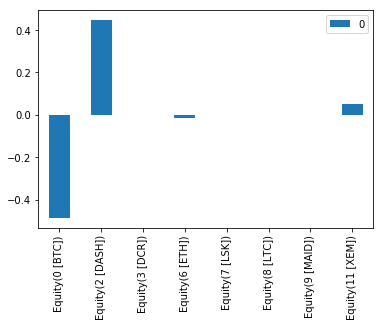

In [141]:
optimal_weights.plot.bar()